In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# Data loading
path = r'../data/interim/data_v3_English.csv'
alzheimer_v3_df = pd.read_csv(path)
alzheimer_v3_df.info()
alzheimer_v3_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            18304 non-null  int64  
 1   Week            18304 non-null  int64  
 2   Date            18304 non-null  object 
 3   Entity          18304 non-null  object 
 4   Epi_Year        18304 non-null  int64  
 5   M               18304 non-null  float64
 6   F               18304 non-null  float64
 7   New_Cases_Week  18304 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.1+ MB


,Year,Week,Date,Entity,Epi_Year,M,F,New_Cases_Week
0,2014,2,2014-01-06,Aguascalientes,2014,0.0,0.0,0.0
1,2014,2,2014-01-06,Baja California,2014,0.0,0.0,0.0
2,2014,2,2014-01-06,Baja California Sur,2014,0.0,0.0,0.0
3,2014,2,2014-01-06,Campeche,2014,0.0,0.0,0.0
4,2014,2,2014-01-06,Chiapas,2014,0.0,0.0,0.0


## Fixing Inconsistencies

In [4]:
alzheimer_df = alzheimer_v3_df.copy()

# Sort by entity and time
df = alzheimer_df.sort_values(['Entity', 'Year', 'Week']).reset_index(drop=True)

# 1. DETECT DECREASES (critical errors)
df['M_prev'] = df.groupby('Entity')['M'].shift(1)
df['F_prev'] = df.groupby('Entity')['F'].shift(1)

# Calculate differences
df['M_diff'] = df['M'] - df['M_prev']
df['F_diff'] = df['F'] - df['F_prev']

# Identify decreases (excluding week 2: natural reset)
df['M_decrease'] = (df['M_diff'] < 0) & (df['Week'] != 2)
df['F_decrease'] = (df['F_diff'] < 0) & (df['Week'] != 2)
df['Has_decrease'] = df['M_decrease'] | df['F_decrease']

print("="*60)
print("STEP 1: DECREASE DETECTION")
print("="*60)
print(f"Decreases in M: {df['M_decrease'].sum()}")
print(f"Decreases in F: {df['F_decrease'].sum()}")
print(f"Total rows with decreases: {df['Has_decrease'].sum()}")

# Show examples
if df['Has_decrease'].sum() > 0:
    print("\nExamples of decreases:")
    examples = df[df['Has_decrease']][['Entity', 'Year', 'Week', 'M', 'F', 'M_diff', 'F_diff']].head(10)
    print(examples)

# 2. DETECT ABNORMAL JUMPS (like in your example)
# Calculate weekly mean and std difference per entity
stats_entity = df.groupby('Entity').agg({
    'M_diff': ['mean', 'std'],
    'F_diff': ['mean', 'std']
}).reset_index()

stats_entity.columns = ['Entity', 'M_diff_mean', 'M_diff_std', 'F_diff_mean', 'F_diff_std']

# Merge stats with main df
df = df.merge(stats_entity, on='Entity', how='left')

# Detect abnormal jumps (> 3 std from mean)
threshold = 3
df['M_abnormal_jump'] = (
    (df['M_diff'] > df['M_diff_mean'] + threshold * df['M_diff_std']) &
    (df['Week'] != 2)
)
df['F_abnormal_jump'] = (
    (df['F_diff'] > df['F_diff_mean'] + threshold * df['F_diff_std']) &
    (df['Week'] != 2)
)
df['Has_abnormal_jump'] = df['M_abnormal_jump'] | df['F_abnormal_jump']

print("\n" + "="*60)
print("STEP 2: ABNORMAL JUMP DETECTION")
print("="*60)
print(f"Abnormal jumps in M: {df['M_abnormal_jump'].sum()}")
print(f"Abnormal jumps in F: {df['F_abnormal_jump'].sum()}")
print(f"Total rows with abnormal jumps: {df['Has_abnormal_jump'].sum()}")

# Show examples
if df['Has_abnormal_jump'].sum() > 0:
    print("\nExamples of abnormal jumps:")
    examples_jumps = df[df['Has_abnormal_jump']][
        ['Entity', 'Year', 'Week', 'M', 'F', 'M_diff', 'F_diff']
    ].head(10)
    print(examples_jumps)

# 3. COMBINED SUMMARY
df['Error_detected'] = df['Has_decrease'] | df['Has_abnormal_jump']

print("\n" + "="*60)
print("TOTAL ERRORS SUMMARY")
print("="*60)
print(f"Total rows with errors: {df['Error_detected'].sum()}")
print(f"Percentage of data with errors: {(df['Error_detected'].sum() / len(df)) * 100:.2f}%")

# Errors by entity
errors_by_entity = df[df['Error_detected']].groupby('Entity').size().sort_values(ascending=False)
print("\nTop 10 entities with most errors:")
print(errors_by_entity.head(10))


STEP 1: DECREASE DETECTION
Decreases in M: 95
Decreases in F: 112
Total rows with decreases: 135

Examples of decreases:
                   Entity  Year  Week     M     F  M_diff  F_diff
94         Aguascalientes  2015    44   3.0   9.0     0.0    -1.0
123        Aguascalientes  2016    21   5.0   9.0   -12.0    -9.0
248        Aguascalientes  2018    42   9.0  14.0    -1.0     1.0
549        Aguascalientes  2024    30   5.0   7.0     0.0    -1.0
606       Baja California  2014    36  20.0  47.0     0.0    -2.0
695       Baja California  2016    21  19.0  27.0   -24.0   -17.0
887       Baja California  2020     5   4.0   4.0     1.0    -1.0
919       Baja California  2020    37  15.0  33.0     0.0    -1.0
1237  Baja California Sur  2015    43   5.0   9.0     0.0    -1.0
1267  Baja California Sur  2016    21   6.0   3.0    -5.0    -3.0

STEP 2: ABNORMAL JUMP DETECTION
Abnormal jumps in M: 31
Abnormal jumps in F: 28
Total rows with abnormal jumps: 38

Examples of abnormal jumps:
        

In [5]:
def sliding_window_correction(df, window=3, std_threshold=2.5):
    """
    Detects outliers using sliding window statistics.
    """
    corrected_df = df.copy()
    corrected_df['M_corrected'] = corrected_df['M'].copy()
    corrected_df['F_corrected'] = corrected_df['F'].copy()
    
    for entity in corrected_df['Entity'].unique():
        mask = corrected_df['Entity'] == entity
        entity_df = corrected_df[mask].sort_values(['Year', 'Week']).copy()
        indices = entity_df.index
        
        # Calculate increments
        entity_df['M_increment'] = entity_df['M'].diff()
        entity_df['F_increment'] = entity_df['F'].diff()
        
        # PASS 1: Detect outliers in increments
        for i in range(window, len(entity_df) - 1):
            if entity_df.iloc[i]['Week'] == 2:
                continue
            
            current_idx = indices[i]
            
            # Context window (exclude current point)
            window_before = entity_df.iloc[i-window:i]
            
            # Increment statistics in the window
            m_inc_mean = window_before['M_increment'].mean()
            m_inc_std = window_before['M_increment'].std()
            
            f_inc_mean = window_before['F_increment'].mean()
            f_inc_std = window_before['F_increment'].std()
            
            # Current increment
            m_inc_current = entity_df.iloc[i]['M_increment']
            f_inc_current = entity_df.iloc[i]['F_increment']
            
            # Detect outlier in M
            if m_inc_std > 0:
                z_score_m = abs((m_inc_current - m_inc_mean) / m_inc_std)
                if z_score_m > std_threshold:
                    # Outlier, interpolate
                    m_prev = corrected_df.loc[indices[i-1], 'M_corrected']
                    m_next = entity_df.iloc[i+1]['M']
                    corrected_df.loc[current_idx, 'M_corrected'] = (m_prev + m_next) / 2
            
            # Detect outlier in F
            if f_inc_std > 0:
                z_score_f = abs((f_inc_current - f_inc_mean) / f_inc_std)
                if z_score_f > std_threshold:
                    f_prev = corrected_df.loc[indices[i-1], 'F_corrected']
                    f_next = entity_df.iloc[i+1]['F']
                    corrected_df.loc[current_idx, 'F_corrected'] = (f_prev + f_next) / 2
        
        # PASS 2: Correct decreases
        for i in range(1, len(indices)):
            current_idx = indices[i]
            prev_idx = indices[i-1]
            
            if corrected_df.loc[current_idx, 'Week'] == 2:
                continue
            
            if corrected_df.loc[current_idx, 'M_corrected'] < corrected_df.loc[prev_idx, 'M_corrected']:
                corrected_df.loc[current_idx, 'M_corrected'] = corrected_df.loc[prev_idx, 'M_corrected']
            
            if corrected_df.loc[current_idx, 'F_corrected'] < corrected_df.loc[prev_idx, 'F_corrected']:
                corrected_df.loc[current_idx, 'F_corrected'] = corrected_df.loc[prev_idx, 'F_corrected']
    
    corrected_df['M_was_corrected'] = (corrected_df['M'] != corrected_df['M_corrected'])
    corrected_df['F_was_corrected'] = (corrected_df['F'] != corrected_df['F_corrected'])
    
    return corrected_df

# Apply sliding window correction method
clean_df = sliding_window_correction(df, window=3, std_threshold=2.5)
clean_df.head()


,Year,Week,Date,Entity,Epi_Year,M,F,New_Cases_Week,M_prev,F_prev,...,F_diff_mean,F_diff_std,M_abnormal_jump,F_abnormal_jump,Has_abnormal_jump,Error_detected,M_corrected,F_corrected,M_was_corrected,F_was_corrected
0,2014,2,2014-01-06,Aguascalientes,2014,0.0,0.0,0.0,NaN,NaN,...,0.024518,2.361109,False,False,False,False,0.0,0.0,False,False
1,2014,3,2014-01-13,Aguascalientes,2014,0.0,0.0,0.0,0.0,0.0,...,0.024518,2.361109,False,False,False,False,0.0,0.0,False,False
2,2014,4,2014-01-20,Aguascalientes,2014,0.0,0.0,0.0,0.0,0.0,...,0.024518,2.361109,False,False,False,False,0.0,0.0,False,False
3,2014,5,2014-01-27,Aguascalientes,2014,0.0,0.0,0.0,0.0,0.0,...,0.024518,2.361109,False,False,False,False,0.0,0.0,False,False
4,2014,6,2014-02-03,Aguascalientes,2014,0.0,0.0,0.0,0.0,0.0,...,0.024518,2.361109,False,False,False,False,0.0,0.0,False,False


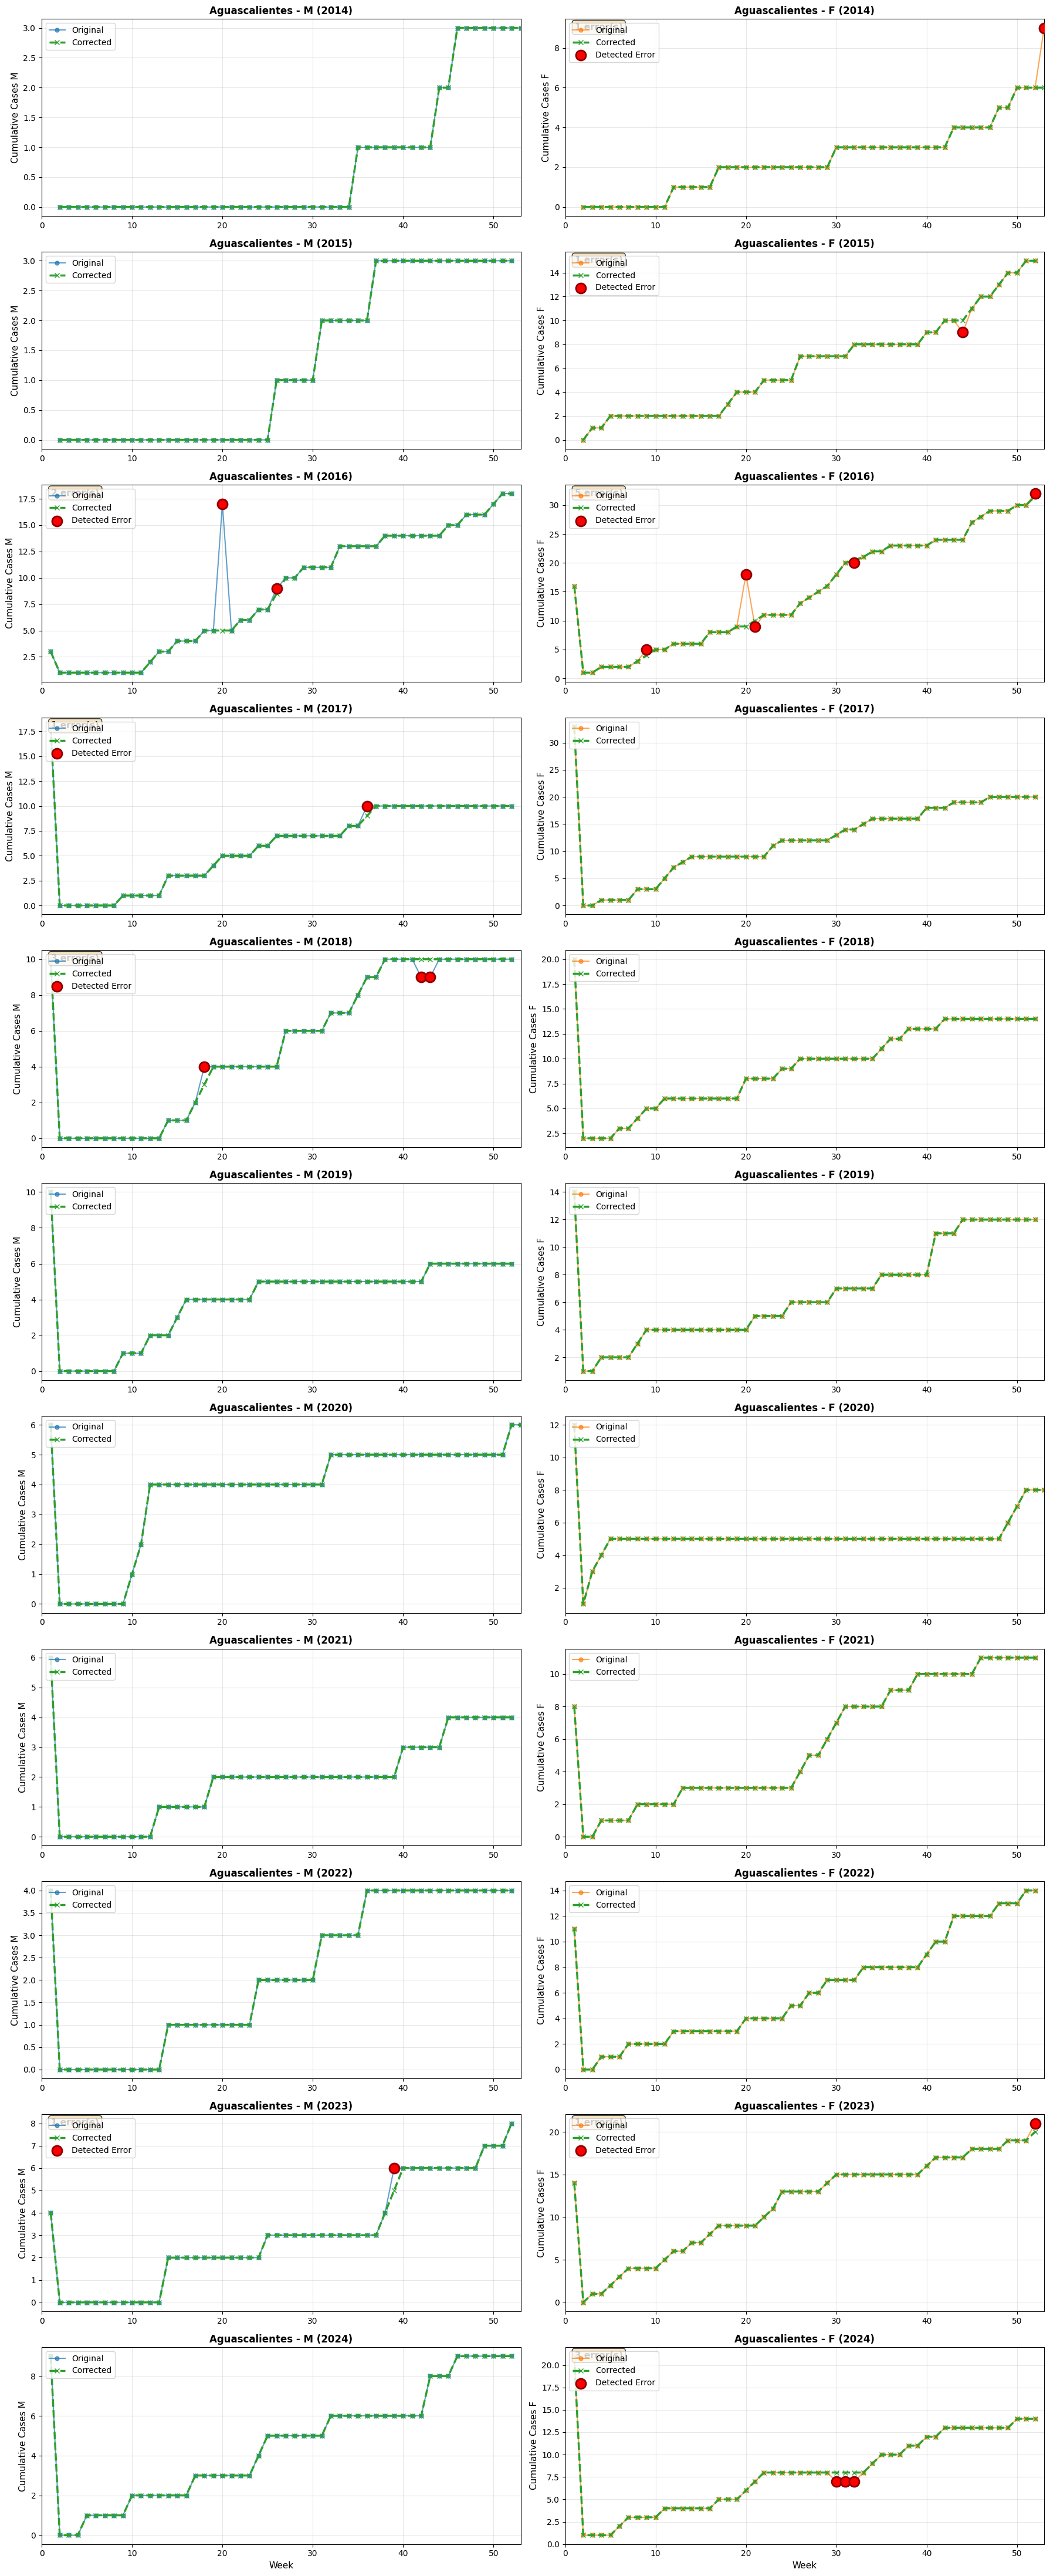


Corrections summary for Aguascalientes:
--------------------------------------------------
Year 2014: 0 errors in M, 1 errors in F
Year 2015: 0 errors in M, 1 errors in F
Year 2016: 2 errors in M, 5 errors in F
Year 2017: 1 errors in M, 0 errors in F
Year 2018: 3 errors in M, 0 errors in F
Year 2019: 0 errors in M, 0 errors in F
Year 2020: 0 errors in M, 0 errors in F
Year 2021: 0 errors in M, 0 errors in F
Year 2022: 0 errors in M, 0 errors in F
Year 2023: 1 errors in M, 1 errors in F
Year 2024: 0 errors in M, 3 errors in F


In [6]:
def plot_corrections_by_year(df_original, df_corrected, entity):
    """
    Visualizes M and F before and after corrections, separated by Year.
    """
    mask = df_original['Entity'] == entity
    df_orig = df_original[mask].copy()
    df_corr = df_corrected[mask].copy()
    
    years = sorted(df_orig['Year'].unique())
    n_years = len(years)
    
    # Create subplots: 2 columns (M and F) x n_years rows
    fig, axes = plt.subplots(n_years, 2, figsize=(18, 4 * n_years))
    
    # If only one year, axes won't be a 2D array
    if n_years == 1:
        axes = axes.reshape(1, -1)
    
    for idx, year in enumerate(years):
        df_orig_year = df_orig[df_orig['Year'] == year]
        df_corr_year = df_corr[df_corr['Year'] == year]
        
        # M plot (left column)
        ax_m = axes[idx, 0]
        ax_m.plot(df_orig_year['Week'], df_orig_year['M'], 
                  'o-', label='Original', markersize=5, alpha=0.7, color='#1f77b4')
        ax_m.plot(df_corr_year['Week'], df_corr_year['M_corrected'], 
                  'x--', label='Corrected', markersize=6, linewidth=2.5, color='#2ca02c')
        
        # Mark corrections in M
        corrections_m = df_corr_year[df_corr_year['M_was_corrected']]
        if len(corrections_m) > 0:
            ax_m.scatter(corrections_m['Week'], corrections_m['M'], 
                         color='red', s=150, zorder=5, marker='o', 
                         edgecolors='darkred', linewidth=2, label='Detected Error')
            
            # Add corrections counter
            n_errors = len(corrections_m)
            ax_m.text(0.02, 0.98, f'{n_errors} error(s)', 
                      transform=ax_m.transAxes, fontsize=11, weight='bold',
                      verticalalignment='top', 
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax_m.set_ylabel('Cumulative Cases M', fontsize=11)
        ax_m.set_title(f'{entity} - M ({year})', fontsize=12, weight='bold')
        ax_m.legend(loc='upper left', fontsize=10)
        ax_m.grid(True, alpha=0.3)
        ax_m.set_xlim(0, 53)
        
        # F plot (right column)
        ax_f = axes[idx, 1]
        ax_f.plot(df_orig_year['Week'], df_orig_year['F'], 
                  'o-', label='Original', markersize=5, alpha=0.7, color='#ff7f0e')
        ax_f.plot(df_corr_year['Week'], df_corr_year['F_corrected'], 
                  'x--', label='Corrected', markersize=6, linewidth=2.5, color='#2ca02c')
        
        # Mark corrections in F
        corrections_f = df_corr_year[df_corr_year['F_was_corrected']]
        if len(corrections_f) > 0:
            ax_f.scatter(corrections_f['Week'], corrections_f['F'], 
                         color='red', s=150, zorder=5, marker='o',
                         edgecolors='darkred', linewidth=2, label='Detected Error')
            
            # Add corrections counter
            n_errors = len(corrections_f)
            ax_f.text(0.02, 0.98, f'{n_errors} error(s)', 
                      transform=ax_f.transAxes, fontsize=11, weight='bold',
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax_f.set_ylabel('Cumulative Cases F', fontsize=11)
        ax_f.set_title(f'{entity} - F ({year})', fontsize=12, weight='bold')
        ax_f.legend(loc='upper left', fontsize=10)
        ax_f.grid(True, alpha=0.3)
        ax_f.set_xlim(0, 53)
        
        # Add Week label only to last row
        if idx == n_years - 1:
            ax_m.set_xlabel('Week', fontsize=11)
            ax_f.set_xlabel('Week', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    # Corrections summary
    total_m = df_corr[df_corr['M_was_corrected']].groupby('Year').size()
    total_f = df_corr[df_corr['F_was_corrected']].groupby('Year').size()
    
    print(f"\nCorrections summary for {entity}:")
    print("-" * 50)
    for year in years:
        n_m = total_m.get(year, 0)
        n_f = total_f.get(year, 0)
        print(f"Year {year}: {n_m} errors in M, {n_f} errors in F")

# Usage
entities_with_errors = df[df['Error_detected']]['Entity'].unique()
if len(entities_with_errors) > 0:
    plot_corrections_by_year(df, clean_df, entities_with_errors[0])

In [ ]:
clean_df_v1 = clean_df[['Year', 'Week', 'Date', 'Entity', 'Epi_Year', 'M_corrected', 'F_corrected']].copy()
clean_df_v1 = clean_df_v1.rename(columns={'M_corrected': 'M', 'F_corrected': 'F'})
# output_folder = '../data/processed/'
# filename = 'data_processed_v3.csv'
# path = os.path.join(output_folder, filename)

# clean_df_v1.to_csv(
#     path,
#     index=False,
#     encoding='utf-8'
# )

print(clean_df_v1.info())
clean_df_v1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      18304 non-null  int64  
 1   Week      18304 non-null  int64  
 2   Date      18304 non-null  object 
 3   Entity    18304 non-null  object 
 4   Epi_Year  18304 non-null  int64  
 5   M         18304 non-null  float64
 6   F         18304 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 1001.1+ KB
None


,Year,Week,Date,Entity,Epi_Year,M,F
0,2014,2,2014-01-06,Aguascalientes,2014,0.0,0.0
1,2014,3,2014-01-13,Aguascalientes,2014,0.0,0.0
2,2014,4,2014-01-20,Aguascalientes,2014,0.0,0.0
3,2014,5,2014-01-27,Aguascalientes,2014,0.0,0.0
4,2014,6,2014-02-03,Aguascalientes,2014,0.0,0.0
